Introduction:
Imbalanced dataset can impact the accuracy of classication models. Using `Logistic Regression` as a baseline. 
In the `pre-processing` step, I will perform a task that detect / remove anomalous data 
Outliers, or anomalies, can impact the accuracy of both regression and classification models, so detecting and removing them is an important step in the machine learning process. On larger datasets, detecting and removing outliers is much harder, so data scientists often apply automated anomaly detection algorithms, such as the Isolation Forest, to help identify and remove outliers.

As the name suggests, the Isolation Forest is a tree-based anomaly detection algorithm. It uses an unsupervised learning approach to detect unusual data points which can then be removed from the training data. The re-training of the model on a data set with the outliers removed generally sees performance increase.

In [1]:
import pandas as pd # for data manipulation

from sklearn.cluster import DBSCAN # for building a clustering model
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn import metrics # for calculating Silhouette score

import matplotlib.pyplot as plt # for data visualization
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
import numpy as np

import seaborn as sns



In [2]:
df_train  = pd.read_csv("df_train.csv", index_col=0)

In [ ]:
file = "s3://dash-879281191186-prod-s3-data-wip/jbc-edge-manual-data-egress/sgss/sgss_positve_ct_results/v1/full/sgss_positive_ct_results_20211123.csv"
df = pd.read_csv(file)

- Error if Delta and S_Gene is not present
- Alpha doesnt have S_Gene
- If still see recent alpha, possibly error due to low prevalence in population.


In [ ]:
#df.where(df.LFT_Flag.str.contains('PCR') & ~df.LFT_Flag.str.contains)
df = df[(df.Specimen_Date.notna()) & (df.LFT_Flag.str.contains('PCR')) ]
df['Delta'] = np.where((df.VAM_Profile=='B.1.617.2') | (df.VAM_Profile=='VOC-21APR-02'),1,0)

df_train = df[(df.Delta==1) | (df.VAM_Profile=='UNDETERMINED')].copy()

In [ ]:
df['ORF1ab'] = pd.to_numeric(df['ORF1ab'], errors='coerce').dropna()
df['N gene'] = pd.to_numeric(df['N gene'], errors='coerce').dropna()

In [ ]:
delta_test = df.copy()
delta_test = delta_test[~(delta_test['ORF1ab']==0) & ~(delta_test['N gene']==0) & ~(delta_test['S gene']==0)]
delta_test = delta_test[delta_test['Delta']==1]
delta_test = delta_test[['ORF1ab' , 'N gene', 'S gene']]


ndelta_test = df[df['VAM_Profile']=="UNDETERMINED"]
ndelta_test = ndelta_test[~(ndelta_test['ORF1ab']==0) & ~(ndelta_test['N gene']==0) & ~(ndelta_test['S gene']==0)]
ndelta_test = ndelta_test[['ORF1ab' , 'N gene', 'S gene']]

len(ndelta_test) / (len(ndelta_test)+len(delta_test))


In [ ]:
sns.pairplot(delta_test[['ORF1ab' , 'N gene', 'S gene']])
sns.pairplot(ndelta_test[['ORF1ab' , 'N gene', 'S gene']])

In [ ]:
df_train['N gene'] = pd.to_numeric(df_train['N gene'], downcast="float")
df_train['ORF1ab'] = pd.to_numeric(df_train['ORF1ab'], downcast="float")
gene = ['Specimen_Date', 'ORF1ab' , 'N gene', 'S gene', 'Delta', 'Symptomatic', 'TRAVEL_ABROAD_INDICATOR', 'Patient_Sex', 'age_group']
df_train = df_train[gene]
df_train.info()
#df_train[df_train[gene].sum(axis=1)>0].describe()

In [ ]:
df_train.head(10).to_csv("small.csv")

In [ ]:
# Gene target of interest 


In [3]:
df_train.head(1)

,ORF1ab,N gene,S gene,Delta,Symptomatic,Patient_Sex,age_group,SGTF
7398,27.66,28.25,25.67,0,1,0,35-44,NaN


Missing

In [ ]:
import seaborn as sns
sns.pairplot(df_train[['ORF1ab','N gene', 'S gene']])

Look at categorical variables
- Travel abroad highly imbalanced, remove it
- around 51:49 female:male proportion in the sample
- around 63:37 Symptomatic proportion in the sample

In [ ]:
df_train.TRAVEL_ABROAD_INDICATOR.value_counts(normalize=True)

In [ ]:
df_train.Patient_Sex.value_counts(normalize=True)

In [ ]:
df_train.Symptomatic.value_counts(normalize=True)

In [ ]:
df_train.age_group.value_counts(normalize=True)

In [ ]:
df_train.shape 
#(740980)

#### Handling missing data
- Impute
- Remove errors
- Remove variables with no power or 0 sd

In [ ]:
## Error: -1 value
df_train = df_train[~((df_train['ORF1ab']<0) | (df_train['N gene']<0) | (df_train['S gene']<0))]

In [ ]:
## 
df_train.TRAVEL_ABROAD_INDICATOR.value_counts()
df_train = df_train.drop(['TRAVEL_ABROAD_INDICATOR'], axis=1)

In [ ]:
df_train['Symptomatic'] = np.where(df_train['Symptomatic']=="Y",1,0)
df_train['Patient_Sex'] = np.where(df_train['Patient_Sex']=="Female",1,0)


In [ ]:
## feature engineering
df_train['SGTF'] = df_train[(df_train['ORF1ab']>0) & (df_train['N gene']>0) & (df_train['S gene']==0)][['ORF1ab', 'N gene']].mean(axis=1)

In [ ]:
df_train.tail(10)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740980 entries, 7398 to 8011514
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ORF1ab       740980 non-null  float64
 1   N gene       740980 non-null  float64
 2   S gene       740980 non-null  float64
 3   Delta        740980 non-null  int64  
 4   Symptomatic  740980 non-null  int64  
 5   Patient_Sex  740980 non-null  int64  
 6   age_group    740963 non-null  object 
 7   SGTF         0 non-null       float64
dtypes: float64(4), int64(3), object(1)
memory usage: 50.9+ MB


In [ ]:
import seaborn as sns 
#sns.displot(df_train, x="ORF1ab", kind="kde")
df_train = df_train[~(df_train['ORF1ab']==0) & ~(df_train['N gene']==0) & ~(df_train['S gene']==0)]

In [ ]:
#df_train.to_csv("df_train.csv")

In [ ]:
#sns.displot(df_train, x="N gene", kind="kde")
ct = df_train[['Patient_Sex', 'ORF1ab']].melt(id_vars='Patient_Sex', var_name='ORF1ab', value_name='Ct').append(
            df_train[['Patient_Sex', 'N gene']].melt(id_vars='Patient_Sex', var_name='ORF1ab', value_name='Ct')).append(
            df_train[['Patient_Sex', 'S gene']].melt(id_vars='Patient_Sex', var_name='ORF1ab', value_name='Ct')
            )

In [ ]:
ct = ct.rename(columns={"ORF1ab": "Gene"})

In [ ]:
sns.displot(ct, x="Ct", hue="Gene", kind="kde")


In [1]:
from sklearn import preprocessing

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df_train['age_group'])
df_train['age_group'] = le.transform(df_train['age_group'])



In [6]:
df_train.columns

Index(['ORF1ab', 'N gene', 'S gene', 'Delta', 'Symptomatic', 'Patient_Sex',
       'age_group', 'SGTF'],
      dtype='object')

In [21]:
## normalise 3 numerical columns
scaler = StandardScaler()
#roburst = RobustScaler()
X = df_train[['ORF1ab', 'N gene', 'S gene','Symptomatic', 'Patient_Sex','age_group']]
scaler.fit(X)
StandardScaler()
scale_X = scaler.transform(X)

#sns.displot(scale_X, kind="kde")

#sns.displot(roburst_X, kind="kde")


## Feature Engineering

In [ ]:
## Week number


In [ ]:
#df_train['date']=pd.to_datetime(df_train['Specimen_Date'])
#df_train['date'] = pd.to_datetime(df_train['date'])
#df_train['week'] =  df['date'] - pd.to_timedelta(df_train['date'].dt.weekday, unit='D')


In [ ]:
## Alpha isnt new so will drop it and only look at Delta and others


In [ ]:
delta = df_train[df_train.Delta==1]
other = df_train[df_train.Delta==0]

In [ ]:
# Proportion of data
len(delta)/(len(delta)+len(other))

In [6]:
from sklearn.metrics import classification_report,accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

In [ ]:
count_classes = pd.value_counts(df_train['Delta'], sort = True)
_ =count_classes.plot(kind = 'bar', rot=0)
plt.title("Variant Distribution")
plt.xticks(range(len(df_train['Delta'].unique())), df_train['Delta'].unique())
plt.xlabel("Class")
plt.ylabel("Frequency")

In [ ]:
df_train.Delta.value_counts()

## Start here

## Logistic Regression
For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the negative ('Not Delta'), I will take the inverse of that. In other words, always predicting the most common outcome.

For this case, 14078/(726902+14078) = ~0.02

So a good target to beat would be 2.5%~ for recall for specimen other then of delta variant.

In [7]:
!pip install imblearn
!pip install boruta

     |████████████████████████████████| 189 kB 14.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 56 kB 6.8 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
df_train['Subvariant'] = np.where(df_train['Delta']==1,0,1)
df_train['Subvariant'].value_counts()

0    726902
1     14078
Name: Subvariant, dtype: int64

In [ ]:
df_train['Subvariant'].value_counts()[1]

In [9]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing


from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import shap
import warnings
warnings.filterwarnings('ignore')

In [26]:
print('Inverse of Null Accuracy: ',14078/(14078+726902))
print('Null Accuracy: ',726902/(14078+726902))

Inverse of Null Accuracy:  0.018999163270263703
Null Accuracy:  0.9810008367297363


In [29]:
df_train['Subvariant'].value_counts()
df_train.columns

Index(['ORF1ab', 'N gene', 'S gene', 'Delta', 'Symptomatic', 'Patient_Sex',
       'age_group', 'Subvariant'],
      dtype='object')

In [10]:
#Get Target data 
y = df_train['Subvariant']
X = df_train[['age_group', 'ORF1ab','N gene', 'S gene', 'Symptomatic', 'Patient_Sex']]



In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, stratify=y, random_state=111)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(185245, 6)
(185245, 6)
(370490, 6)


In [13]:
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [ ]:
clf_log = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=111))])
clflog_cv = cross_val_score(clf_log,X_train_resh,y_train_resh,cv=10,scoring='f1')

print('Mean f1 scores:')
print('Logistic Regression mean :',cross_val_score(clf_log ,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression recall :',cross_val_score(clf_log ,X_train_resh,y_train_resh,cv=10,scoring='recall').mean())
print('Logistic Regression F2 :',cross_val_score(clf_log ,X_train_resh,y_train_resh,cv=10,scoring='beta2').mean())


In [ ]:
clf_log.fit

In [29]:
model = LogisticRegression(random_state=111)
# fit the model
model.fit(X, y)
importance = model.coef_[0]


Feature: 0, Score: 0.00590
Feature: 1, Score: 0.06400
Feature: 2, Score: -0.10339
Feature: 3, Score: 0.19560
Feature: 4, Score: -0.01984
Feature: 5, Score: 0.00963


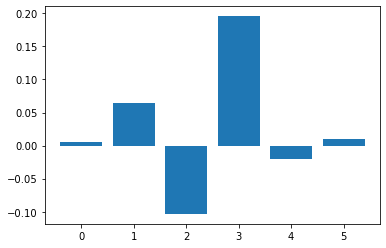

In [24]:
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

In [26]:
X.columns

# 

Index(['age_group', 'ORF1ab', 'N gene', 'S gene', 'Symptomatic',
       'Patient_Sex'],
      dtype='object')

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)

trans = BorutaPy(clf, random_state=42, verbose=2)
sel = trans.fit_transform(X.values, y.values)

In [32]:
clf_log.fit(X_train_resh,y_train_resh)
pred   = clf_log.predict(X_test)
logreg_cm  = confusion_matrix(y_test,pred )

clf_f1  = f1_score(y_test,pred)

In [ ]:
print('Mean f1 scores:')
print('LR mean :',clf_f1)

In [36]:
print(classification_report(y_test,pred))
print('Accuracy Score: ',accuracy_score(y_test,pred))
print('F1 Score: ',f1_score(y_test,pred))
print('F2 Score: ',fbeta_score(y_pred=pred, y_true=y_test.values, beta=2))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80    363451
           1       0.03      0.58      0.06      7039

    accuracy                           0.67    370490
   macro avg       0.51      0.63      0.43    370490
weighted avg       0.97      0.67      0.79    370490

Accuracy Score:  0.6714081351723393
F1 Score:  0.0628175519630485
F2 Score:  0.13508412960130317


In [ ]:
param_grid = [    
    {'LR__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'LR__C' : [0.01, 0.1, 1, 10, 100],
    'LR__solver' : ['lbfgs','newton-cg','liblinear'],
    'LR__max_iter' : [100, 1000,2500, 5000]
    }
]
clf_log.get_params().keys()

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.01, 0.1, 1, 10],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'max_iter' : [10, 100, 1000]
    }
]
log_reg.get_params().keys()

In [ ]:
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression()
grid = GridSearchCV(log_reg,param_grid)
grid.fit(X_train_resh,y_train_resh)
grid.best_params_


In [ ]:
clf_pipeline = Pipeline(steps = [('scale',StandardScaler())
                                 ,('LR',LogisticRegression(C=0.1
                                                        , max_iter=10
                                                        ,penalty='l1'
                                                        ,solver = 'liblinear'         
                                                        ,random_state=42))])

clf_pipeline.fit(X_train_resh,y_train_resh)
clf_tuned_pred   = clf_pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test,clf_tuned_pred ))

print('Accuracy Score: ',accuracy_score(y_test,clf_tuned_pred ))
print('F1 Score: ',f1_score(y_test,clf_tuned_pred ))

In [37]:
cm1 = confusion_matrix(y_test, pred)
cm1

array([[244670, 118781],
       [  2959,   4080]])

In [38]:
print(cm1[0,1],'Type I errors( False Positives)')
print(cm1[1,0],'Type II errors( False Negatives)')
           
print('Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])))
print('Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])))

118781 Type I errors( False Positives)
2959 Type II errors( False Negatives)
Sensitivity:  0.5796277880380736
Specificity:  0.6731856563883439


In [ ]:
df_train.columns

In [40]:
#Create independent and Dependent Features
#columns = df.columns.tolist()

# Remove Target 
#columns = [c for c in columns if c not in ["Subvariant"]]

# Store Target
target = "Subvariant"

# Define a random state 
state = np.random.RandomState(111)

LABELS = ['ORF1ab','N gene','S gene']

X = df_train[LABELS]
Y = df_train[target]

X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(740980, 3)
(740980,)


In [ ]:
anomaly = df_train[df_train.Subvariant==1].drop(['Delta', 'Symptomatic', 'Patient_Sex'], axis=1)
#.drop('Specimen_Date', axis=1)
normal = df_train[df_train.Subvariant==0].drop(['Delta', 'Symptomatic', 'Patient_Sex'], axis=1)
#.drop('Specimen_Date', axis=1)
outlier_fraction = len(anomaly)/float(len(normal))
outlier_fraction

In [ ]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.5, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = df_train
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Subvariant'].mean())
print('Valid: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Subvariant'].mean())
print('Test:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Subvariant'].mean())

In [ ]:
normal.to_csv("normal.csv")
anomaly.to_csv("anomaly.csv")

In [44]:
normal = pd.read_csv("normal.csv", index_col=0)
anomaly = pd.read_csv("anomaly.csv", index_col=0)

In [ ]:
train = train.drop('SGTF',axis=1)
    #['Delta', 'Symptomatic', 'Patient_Sex', 'age_group'], axis=1)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Subvariant', axis=1).values)
print(gmm.score(valid[valid['Subvariant'] == 0].drop('Subvariant', axis=1).values))
print(gmm.score(valid[valid['Subvariant'] == 1].drop('Subvariant', axis=1).values))

In [ ]:
tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Subvariant', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Subvariant'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Subvariant'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Subvariant'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

In [ ]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Subvariant', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Subvariant'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Subvariant'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Subvariant'].values, beta=2))

cnf_matrix = confusion_matrix(test['Subvariant'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

In [ ]:
from sklearn.ensemble import IsolationForest
np.random.seed(42)

model = IsolationForest(random_state=42, n_jobs=4, max_samples=train.shape[0], bootstrap=True, n_estimators=50)
model.fit(train.drop('Subvariant', axis=1).values)
print(model.decision_function(valid[valid['Subvariant'] == 0].drop('Subvariant', axis=1).values).mean())
print(model.decision_function(valid[valid['Subvariant'] == 1].drop('Subvariant', axis=1).values).mean())

In [ ]:
tresholds = np.linspace(-.2, .2, 200)
y_scores = model.decision_function(valid.drop('Subvariant', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Subvariant'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Subvariant'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Subvariant'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

In [ ]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Subvariant', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Subvariant'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Subvariant'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Subvariant'].values, beta=2))

cnf_matrix = confusion_matrix(test['Subvariant'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

In [ ]:
import pickle

In [ ]:
#filename = 'clf_pipeline_tuned.sav'
#pickle.dump(clf_pipeline, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [41]:
## Novelty Detection

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=10, max_samples=len(X), 
                                       verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.025),
   # "EllipticEnvelope": EllipticEnvelope(contamination=0.025, random_state=111)
    
    "Support Vector Machine":OneClassSVM(degree=3, gamma=0.1,nu=0.025, 
                                         max_iter=-1)
   
}

In [ ]:
iForest = IsolationForest()
iForest.fit(X)
iForest.get_params().keys()

In [ ]:
outlier_fraction

In [ ]:
iForest = IsolationForest(n_estimators=10, max_samples=len(X), 
                                       verbose=0, contamination = 0.025)
iForest.fit(X)

In [ ]:
tresholds = np.linspace(-.2, .2, 200)
y_scores = iForest.decision_function(X)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=Y),
                 precision_score(y_pred=y_hat, y_true=Y),
                 fbeta_score(y_pred=y_hat, y_true=Y, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

In [ ]:
socres

In [ ]:
param_grid_nov = [    
    { 'contamination': [0,0.02,0.05]
    }
]

## Isolation forest doesnt have its own sore, create my own
def scorer_f(estimator, X):   # my own scorer
      return np.mean(estimator.score_samples(X))

grid_iForest = GridSearchCV(iForest,param_grid_nov, scorer_f)
grid_iForest.fit(X_train,y_train)
grid_iForest.best_params_

In [ ]:
import pickle
import time

In [ ]:
t0 = time.time()
clf_cov = EllipticEnvelope(contamination=0.025, random_state=111).fit(X)

y_pred_cov = clf_cov.predict(X)
t1 = time.time()
print(f'time taken {(t1 - t0)}')
filename = 'cov.sav'
pickle.dump(clf_cov, open(filename, 'wb'))

In [ ]:
filename="cov.sav"
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.predict(X_test, y_test)


In [ ]:
y_pred_cov[y_pred_cov == 1] = 0
y_pred_cov[y_pred_cov == -1] = 1
n_errors = (y_pred_cov != Y).sum()
# Run Classification Metrics
print("{}: {}".format(clf_cov,n_errors))
print("Accuracy Score :")
print(accuracy_score(Y,y_pred_cov))
print("Classification Report :")
print(classification_report(Y,y_pred_cov))

In [ ]:
clf_if = IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, contamination=0.0001, bootstrap=False, n_jobs=-1, random_state=111, verbose=0)

clf_if.fit(X)
scores_prediction = clf_if.decision_function(X)
y_pred_if = clf_if.predict(X)

In [ ]:
(unique, counts) = np.unique(y_pred_if, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
y_pred_if
y_pred_if[y_pred_if == 1] = 0
y_pred_if[y_pred_if == -1] = 1
n_errors = (y_pred_if != Y).sum()
# Run Classification Metrics
print("{}: {}".format(clf_if,n_errors))
print("Accuracy Score :")
print(accuracy_score(Y,y_pred_if))
print("Classification Report :")
print(classification_report(Y,y_pred_if))

In [ ]:
filename="iForest.sav"
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_train, y_train)


In [ ]:
y_pred_if[y_pred_cov == 1] = 0
y_pred_if[y_pred_cov == -1] = 1
n_errors = (y_pred_cov != Y).sum()
# Run Classification Metrics
print("{}: {}".format(clf_cov,n_errors))
print("Accuracy Score :")
print(accuracy_score(Y,y_pred_cov))
print("Classification Report :")
print(classification_report(Y,y_pred_cov))

In [48]:
import time 
n_outliers = len(anomaly)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        t0 = time.time()
        y_pred_lof = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
        t1 = time.time()
        print(f'time taken {(t1 - t0)}')
        filename = 'LOF.sav'
       # pickle.dump(clf, open(filename, 'wb'))
    elif clf_name == "Support Vector Machine":
        t0 = time.time()
        clf.fit(X)
        y_pred = clf.predict(X)
        t1 = time.time()
        print(f'time taken {(t1 - t0)}')
        filename = 'OCSVM.sav'
    #    pickle.dump(clf, open(filename, 'wb'))
    
    else:    
        t0 = time.time()
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        t1 = time.time()
        print(f'time taken {(t1 - t0)}')
       # filename = 'iForest.sav'
      #  pickle.dump(clf, open(filename, 'wb'))
        ## use SHAP to interpret model
       # exp = shap.TreeExplainer(clf) #Explainer
       # shap_values = exp.shap_values(X)  #Calculate SHAP values
        #shap.initjs()
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

time taken 12.5560302734375
Isolation Forest: 25941
Accuracy Score :
0.9649909579205916
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    726902
           1       0.13      0.14      0.13     14078

    accuracy                           0.96    740980
   macro avg       0.55      0.56      0.56    740980
weighted avg       0.97      0.96      0.97    740980

time taken 13.666722536087036
Local Outlier Factor: 14078
Accuracy Score :
0.9810008367297363
Classification Report :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    726902
           1       0.00      0.00      0.00     14078

    accuracy                           0.98    740980
   macro avg       0.49      0.50      0.50    740980
weighted avg       0.96      0.98      0.97    740980



KeyboardInterrupt: 